# Analyse de données du naufrage du Titanic

Méthodes Statistiques pour méga-données, mai 2016

Benjamin Rouif
Stanislas Thiery

**Procédure d'instalation**:

Nous recommendons de placer ce notebook dans un dossier et d'initialiser un environement Python virtuel grâce à Virtuelenv. Il est également nécessaire d'installer Graphviz pour obtenir les arbres de régression en image .png (pour cela, on fera `brew install graphviz`).

Les modules Python requis pour ce notebook sont:
* matplotlib
* numpy
* pandas
* sklearn
* IPython
* pydot
* seaborn
* random

In [143]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn import datasets, svm, linear_model, cross_validation, tree, ensemble, neighbors, naive_bayes
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import KFold
from IPython.display import Image 
from sklearn.externals.six import StringIO  
import pydot
import seaborn as sns
import statsmodels.api as sm 
import random

## Chargement des donnée

In [2]:
df = pd.read_csv("data/train.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


## Analyse statistique des données

Tout d'abord, on regarde les données brutes issues du site Kaggle.

In [144]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Ticket_Party,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_NoClue,Cabin_T
0,1,0,3,"Braund, Mr. Owen Harris",1.0,22.0,1.0,0.0,A/5 21171,7.2500,...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0.0,38.0,1.0,0.0,PC 17599,71.2833,...,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1,3,"Heikkinen, Miss. Laina",0.0,26.0,0.0,0.0,STON/O2. 3101282,7.9250,...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0.0,35.0,1.0,0.0,113803,26.5500,...,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0,3,"Allen, Mr. William Henry",1.0,35.0,0.0,0.0,373450,8.0500,...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


On crée ensuite une fonction pour préparer les données à notre analyse statistique.

In [145]:
def data_prep_analysis(df, drop=True):
    
    title_d = {'Mr': 'Mr', 'Miss': 'Miss', 'Mrs': 'Mrs', 'Master':'Officer', 'Dr':'Dr', 
           'Rev':'Rev', 'Major':'Officer', 'Col':'Officer', 'Mlle': 'Miss', 'Jonkheer':'Royalty',
           'Ms': 'Miss', 'Don':'Royalty', 'Mme':'Mrs', 'Capt':'Officer', 'Lady':'Royalty', 'theCountess': 'Royalty',
           'Dona':'Royalty', 'Sir':'Royalty'}
    
    passenger_ticket_d = df.groupby('Ticket')['Fare'].count().to_dict()
    ticket_fare_d = (df.groupby('Ticket')['Fare'].mean()/df.groupby('Ticket')['Fare'].count()).to_dict()
    
    # Fare
    df['Fare'] = df['Ticket'].map(lambda x: ticket_fare_d[x]) 
    # Title 
    df.loc[:, 'Title'] = df.Name.map(lambda x: title_d[x.split(',')[1].split('.')[0].replace(' ','')])
    # Ticket prefix / deck 
    df['Cabin'] = df.Cabin.str[0].map(lambda s: np.nan if s == "T" else s)
    # Family Members
    df['Family_Mmbrs'] = df['SibSp'] + df['Parch']
    #Embarkted town
    df['Embarked'] = df.Embarked.map({'C': 'Cherbourg', 'Q': 'Queenstown', 'S': 'Southampton'})
    #Class in string
    df['Class'] = df.Pclass.map({1: 'First', 2: 'Second', 3: 'Third'})
    
    return df

On applique notre fonction aux données chargées.

In [147]:
dfa = data_prep_analysis(df)
print dfa.info() # Verification des colonnes et des données manquantes
dfa.head() # Observation des données brutes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 39 columns):
PassengerId      891 non-null int64
Survived         891 non-null int64
Pclass           891 non-null int64
Name             891 non-null object
Sex              891 non-null float64
Age              891 non-null float64
SibSp            891 non-null float64
Parch            891 non-null float64
Ticket           891 non-null object
Fare             891 non-null float64
Cabin            890 non-null object
Embarked         0 non-null object
MissingInfo      891 non-null int64
Embarked_S       891 non-null float64
Embarked_C       891 non-null float64
Pclass_1         891 non-null float64
Pclass_2         891 non-null float64
Intercept        891 non-null float64
Title            891 non-null object
Title_Dr         891 non-null float64
Title_Miss       891 non-null float64
Title_Mr         891 non-null float64
Title_Mrs        891 non-null float64
Title_Officer    891 non-null float6

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_NoClue,Cabin_T,Family_Mmbrs,Class
0,1,0,3,"Braund, Mr. Owen Harris",1.0,22.0,1.0,0.0,A/5 21171,7.2500,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,Third
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0.0,38.0,1.0,0.0,PC 17599,71.2833,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,First
2,3,1,3,"Heikkinen, Miss. Laina",0.0,26.0,0.0,0.0,STON/O2. 3101282,7.9250,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,Third
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0.0,35.0,1.0,0.0,113803,6.6375,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,First
4,5,0,3,"Allen, Mr. William Henry",1.0,35.0,0.0,0.0,373450,8.0500,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,Third


### Décès et Survivants

In [148]:
# On définit la charte graphique pour seaborn
title_font = {'fontname':'Arial', 'size':'22', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'}
current_palette = sns.color_palette('colorblind')

/Users/stanislas/Desktop/MLTitanic/kaggle-titanic/env/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


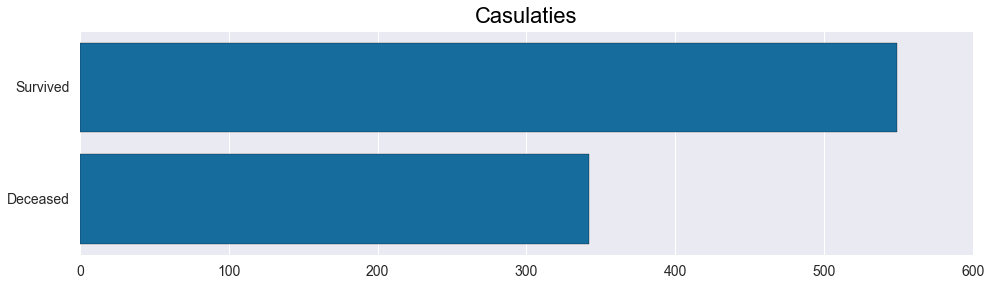

In [149]:
f, ax1 = plt.subplots(1, 1, figsize=(16, 4), sharex=True)
ax1.tick_params(labelsize=14, pad=10)
ax1.set_title('Casulaties', fontdict=title_font)

sns.barplot(y=['Survived','Deceased'], 
            x = dfa.Survived.value_counts().values, 
            ax=ax1, color=current_palette[0])

ax1.legend(ncol=2, loc="lower right", frameon=True, fontsize=14)

### Survie en fonction du sexe

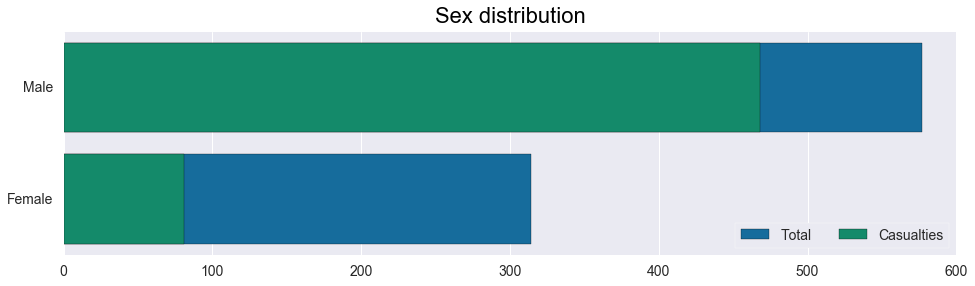

In [150]:
f, ax1 = plt.subplots(1, 1, figsize=(16, 4), sharex=True)
ax1.tick_params(labelsize=14, pad=10)
ax1.set_title('Sex distribution', fontdict=title_font)

sns.barplot(y=['Male', 'Female'], 
            x = dfa.Sex.value_counts().values, 
            ax=ax1, color=current_palette[0], label='Total')
sns.barplot(y=['Male', 'Female'], 
            x = dfa[dfa['Survived']==0].Sex.value_counts().values, 
            ax=ax1, color=current_palette[1],
           label='Casualties')

ax1.legend(ncol=2, loc="lower right", frameon=True, fontsize=14)

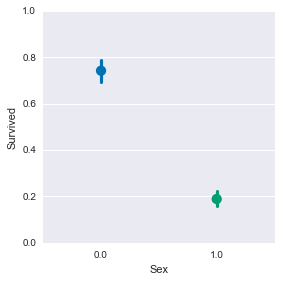

In [158]:
sns.factorplot("Sex", "Survived", data=dfa, palette=current_palette).set(ylim=(0, 1))

### Survie en fonction de la classe

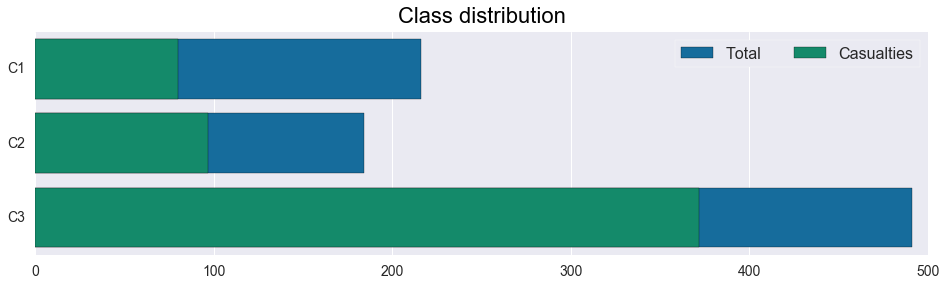

In [152]:
f, ax1 = plt.subplots(1, 1, figsize=(16, 4))
ax1.tick_params(labelsize=14, pad=10)
ax1.set_title('Class distribution', fontdict=title_font)

se = dfa.Pclass.value_counts(sort=False)
se.index = ['C1', 'C2', 'C3']

sns.barplot(y = se.index, 
            x = se.values, 
            ax=ax1, color=current_palette[0], label='Total')

se = dfa[dfa['Survived']==0].Pclass.value_counts(sort=False)
se.index = ['C1', 'C2', 'C3']
sns.barplot(y = se.index, 
            x = se.values, 
            ax=ax1, color=current_palette[1], label='Casualties')

ax1.legend(ncol=2, loc="upper right", frameon=True, fontsize=16)

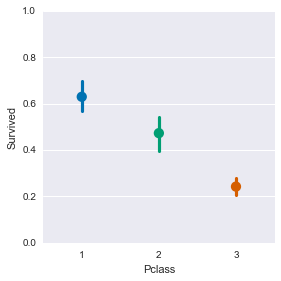

In [161]:
sns.factorplot('Pclass','Survived', data=dfa, palette=current_palette).set(ylim=(0, 1))

On regarde maintenant les taux de survie des différents sexes au sein d'une même classe.

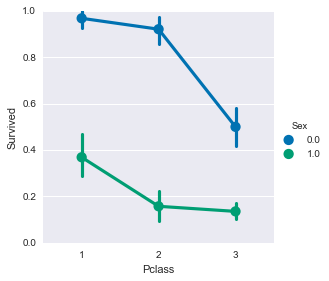

In [162]:
sns.factorplot('Pclass', 'Survived', data=dfa, hue='Sex', palette=current_palette).set(ylim=(0, 1))

### Survie en fonction de l'âge

On répartit les passagers en tranche d'âge de 5 ans.

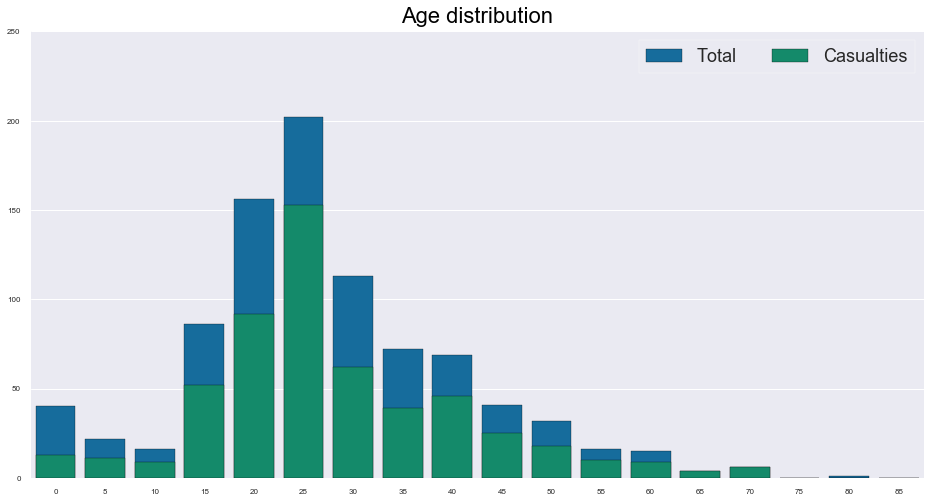

In [156]:
f, ax1 = plt.subplots(1, 1, figsize=(16, 8), sharex=True)
ax1.tick_params(labelsize=8, pad=10)
ax1.set_title('Age distribution', fontdict=title_font)

age_dfa = pd.DataFrame(columns=['Total', 'Casualties'], index=range(int(dfa.Age.min()), int(dfa.Age.max()+6),5))

for i in age_dfa.index:
    age_dfa.loc[i, 'Total'] = ((dfa['Age']>=i)&(dfa['Age']<i+5)).sum()
    age_dfa.loc[i, 'Casualties'] = ((dfa['Age']>=i)&(dfa['Age']<i+5)&(dfa['Survived']==0)).sum()

sns.barplot(y = age_dfa.Total.values, 
            x = age_dfa.index, ax=ax1, color=current_palette[0], label='Total')
sns.barplot(y = age_dfa.Casualties.values,
            x = age_dfa.index, ax=ax1, color=current_palette[1],
            label='Casualties')


ax1.legend(ncol=2, loc="upper right", frameon=True, fontsize=18)

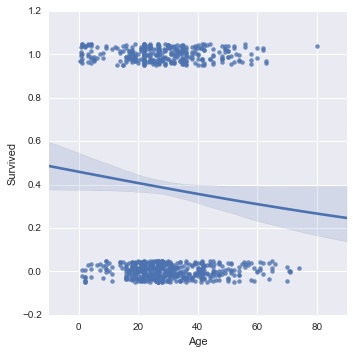

In [163]:
sns.lmplot("Age", "Survived", dfa, logistic=True, y_jitter=.05, palette=current_palette)

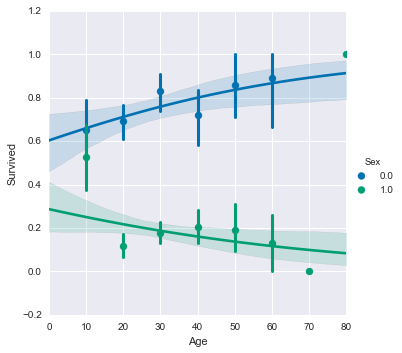

In [166]:
age_bins = [10, 20, 30, 40, 50, 60, 70, 80] 
sns.lmplot("Age", "Survived", dfa, hue="Sex",
           palette=current_palette, x_bins=age_bins, logistic=True).set(xlim=(0, 80))

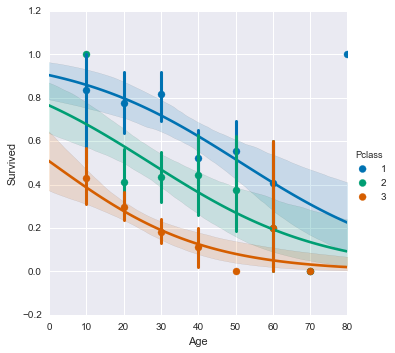

In [167]:
sns.lmplot("Age", "Survived", dfa, hue="Pclass",
           palette=current_palette, x_bins=age_bins, logistic=True).set(xlim=(0, 80))

### Survie en fonction du prix du billet

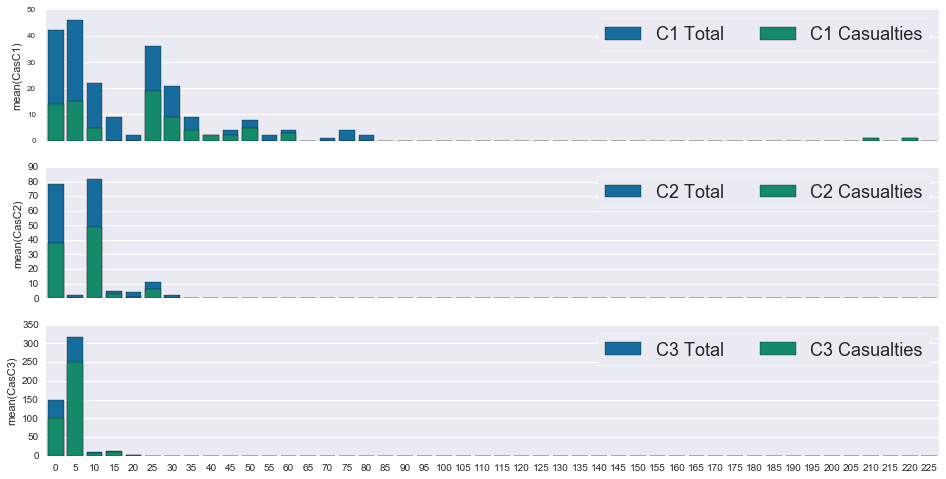

In [168]:
dfa.Fare = dfa.Fare.map(lambda x: int(x))

fare_max = int(dfa.Fare.max())
fare_min = int(dfa.Fare.min())

fare_dfa = pd.DataFrame(columns=['C1','C2','C3','CasC1','CasC2','CasC3'], index = range(fare_min, fare_max+6,5))
for i in fare_dfa.index: 
    fare_dfa.loc[i, 'C1'] = (((dfa['Fare']>=i)&(dfa['Fare']<i+5)&(dfa['Pclass']==1)).sum())
    fare_dfa.loc[i, 'C2'] = (((dfa['Fare']>=i)&(dfa['Fare']<i+5)&(dfa['Pclass']==2)).sum())
    fare_dfa.loc[i, 'C3'] = (((dfa['Fare']>=i)&(dfa['Fare']<i+5)&(dfa['Pclass']==3)).sum())
    fare_dfa.loc[i, 'CasC1'] = (((dfa['Fare']>=i)&(dfa['Fare']<i+5)&(dfa['Pclass']==1)&(dfa['Survived']==0)).sum())
    fare_dfa.loc[i, 'CasC2'] = (((dfa['Fare']>=i)&(dfa['Fare']<i+5)&(dfa['Pclass']==2)&(dfa['Survived']==0)).sum())
    fare_dfa.loc[i, 'CasC3'] = (((dfa['Fare']>=i)&(dfa['Fare']<i+5)&(dfa['Pclass']==3)&(dfa['Survived']==0)).sum())

f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 8), sharex=True)
ax1.tick_params(labelsize=8, pad=10)

sns.barplot(y = fare_dfa['C1'],
            x = fare_dfa.index, ax=ax1, color=current_palette[0],
            label='C1 Total')
sns.barplot(y = fare_dfa['CasC1'],
            x = fare_dfa.index, ax=ax1, color=current_palette[1],
            label='C1 Casualties')
sns.barplot(y = fare_dfa['C2'],
            x = fare_dfa.index, ax=ax2, color=current_palette[0],
            label='C2 Total')
sns.barplot(y = fare_dfa['CasC2'],
            x = fare_dfa.index, ax=ax2, color=current_palette[1],
            label='C2 Casualties')
sns.barplot(y = fare_dfa['C3'],
            x = fare_dfa.index, ax=ax3, color=current_palette[0],
            label='C3 Total')
sns.barplot(y = fare_dfa['CasC3'],
            x = fare_dfa.index, ax=ax3, color=current_palette[1],
            label='C3 Casualties')

ax1.legend(ncol=2, loc="upper right", frameon=True, fontsize=18)
ax2.legend(ncol=2, loc="upper right", frameon=True, fontsize=18)
ax3.legend(ncol=2, loc="upper right", frameon=True, fontsize=18)

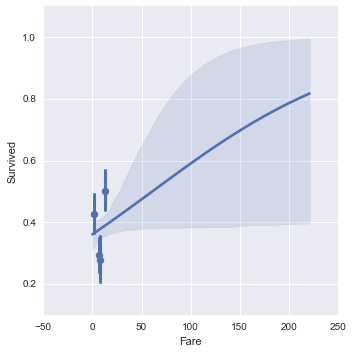

In [170]:
sns.lmplot("Fare", "Survived", dfa, x_bins=4, logistic=True, truncate=True, palette=current_palette)

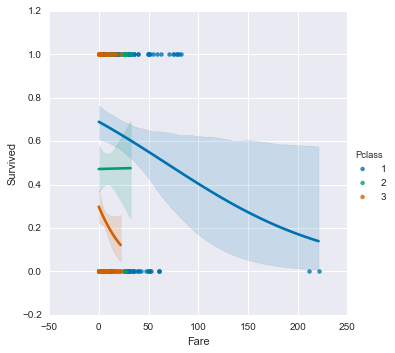

In [171]:
sns.lmplot("Fare", "Survived", dfa, hue="Pclass", logistic=True, truncate=True, palette=current_palette);

### Survie en fonction de l'emplacement de la cabine

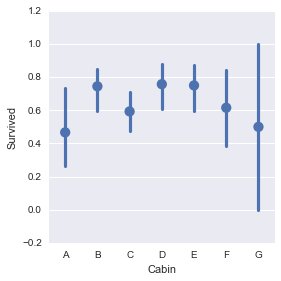

In [172]:
sns.factorplot('Cabin', 'Survived', data=dfa, order='ABCDEFG', join=False);

### Survie en fonction du nombre de relations familiales

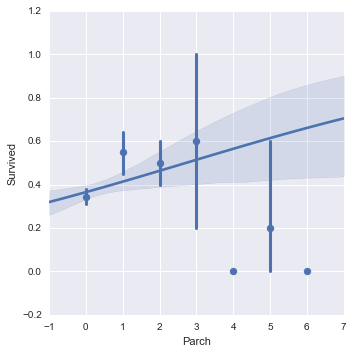

In [234]:
sns.lmplot('Parch', 'Survived', dfa, x_estimator=np.mean, logistic=True)

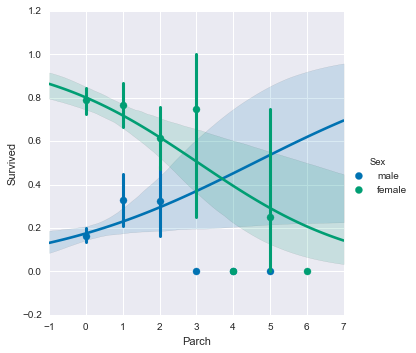

In [236]:
sns.lmplot('Parch', 'Survived', dfa, hue='Sex', x_estimator=np.mean, logistic=True, palette=current_palette)

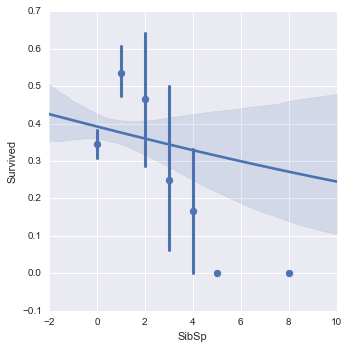

In [26]:
sns.lmplot('SibSp', 'Survived', dfa, x_estimator=np.mean, logistic=True, palette=current_palette)

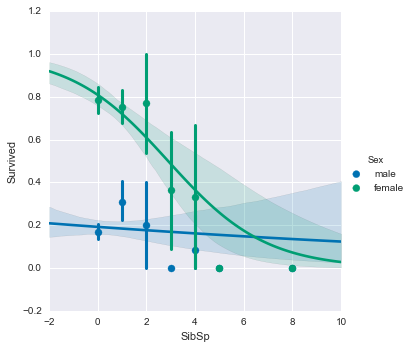

In [23]:
sns.lmplot('SibSp', 'Survived', dfa, hue="Sex", x_estimator=np.mean, logistic=True, palette=current_palette)

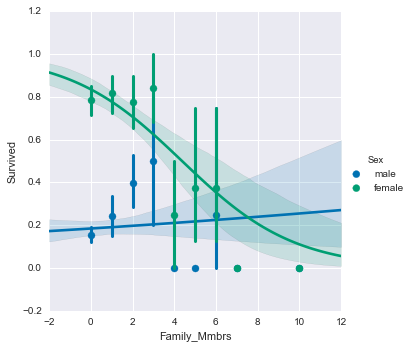

In [24]:
sns.lmplot('Family_Mmbrs', 'Survived', dfa, hue="Sex", x_estimator=np.mean, logistic=True, palette=current_palette)

### Survie en fonction du port d'embarcation

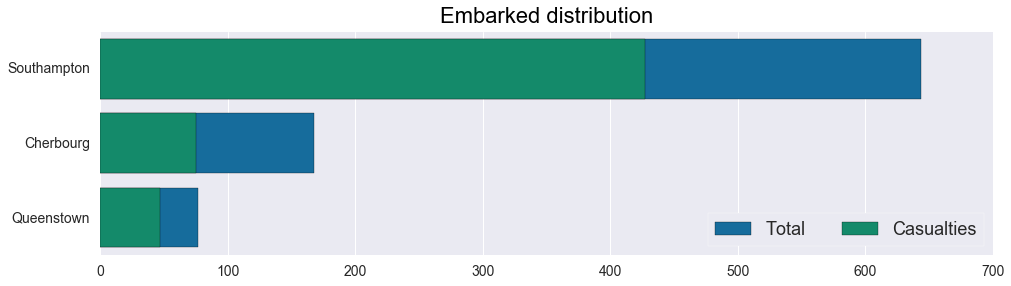

In [239]:
f, ax1 = plt.subplots(1, 1, figsize=(16, 4), sharex=True)
ax1.tick_params(labelsize=14, pad=10)
ax1.set_title('Embarked distribution', fontdict=title_font)

sns.barplot(y=['Southampton', 'Cherbourg', 'Queenstown'], 
            x = dfa.Embarked.value_counts().values, ax=ax1, color=current_palette[0], label='Total')
sns.barplot(y=['Southampton', 'Cherbourg', 'Queenstown'],
            x = dfa[dfa['Survived']==0].Embarked.value_counts().values, ax=ax1, color=current_palette[1],
            label='Casualties')

ax1.legend(ncol=2, loc="lower right", frameon=True, fontsize=18)

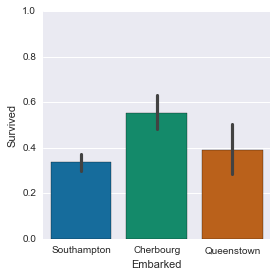

In [30]:
sns.factorplot('Embarked','Survived', data=dfa, kind="bar", palette=current_palette).set(ylim=(0, 1))

### Survie en fonction du titre honorofique

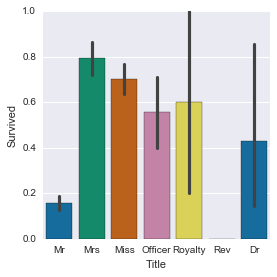

In [33]:
sns.factorplot('Title','Survived', data=dfa, kind="bar", palette=current_palette).set(ylim=(0, 1))

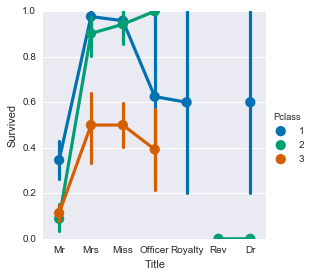

In [34]:
sns.factorplot('Title', 'Survived', data=dfa, hue='Pclass', palette=current_palette).set(ylim=(0, 1))

## Machine Learning/Modélisation

In [175]:
predicted = 'Survived'

In [174]:
def data_prep(df, drop=True):
    
    title_d = {'Mr': 'Mr', 'Miss': 'Miss', 'Mrs': 'Mrs', 'Master':'Officer', 'Dr':'Dr', 
           'Rev':'Rev', 'Major':'Officer', 'Col':'Officer', 'Mlle': 'Miss', 'Jonkheer':'Royalty',
           'Ms': 'Miss', 'Don':'Royalty', 'Mme':'Mrs', 'Capt':'Officer', 'Lady':'Royalty', 'theCountess': 'Royalty',
           'Dona':'Royalty', 'Sir':'Royalty'}
    
    passenger_ticket_d = df.groupby('Ticket')['Fare'].count().to_dict()
    ticket_fare_d = (df.groupby('Ticket')['Fare'].mean()/df.groupby('Ticket')['Fare'].count()).to_dict()
    
    df['MissingInfo'] = df.isnull().sum(axis=1)
    
    # sex
    df.loc[df["Sex"] == "male", "Sex"] = 0.
    df.loc[df["Sex"] == "female", "Sex"] = 1.

    # embarked
    df.loc[df['Embarked'] == "S", "Embarked_S"] = 1.
    df.loc[df['Embarked'] != "S", "Embarked_S"] = 0.
    df.loc[df['Embarked'] == "C", "Embarked_C"] = 1.
    df.loc[df['Embarked'] != "C", "Embarked_C"] = 0.

    # class 
    df.loc[df['Pclass'] == 1, "Pclass_1"] = 1.
    df.loc[df['Pclass'] != 1, "Pclass_1"] = 0.
    df.loc[df['Pclass'] == 2, "Pclass_2"] = 1.
    df.loc[df['Pclass'] != 2, "Pclass_2"] = 0.
    
    # age 
    for pclass in [1,2,3]: 
        for sex in [0,1]: 
            age_filter = (df['Pclass']==pclass)&(df['Sex']==sex)
            df.loc[(df['Age'].isnull())&age_filter,'Age'] = (df[(df['Age']>0)&age_filter])['Age'].mean()

    df.loc[:,'Intercept'] = 1.
    
    # fare 
    df['Fare'] = df['Ticket'].map(lambda x: ticket_fare_d[x]) 
    
    df.loc[(df['Pclass']==1)&df['Fare'].isnull(),'Fare'] = (df[df['Pclass']==1])['Fare'].mean()
    df.loc[(df['Pclass']==2)&df['Fare'].isnull(),'Fare'] = (df[df['Pclass']==2])['Fare'].mean()
    df.loc[(df['Pclass']==3)&df['Fare'].isnull(),'Fare'] = (df[df['Pclass']==3])['Fare'].mean()
    
    # title 
    df.loc[:, 'Title'] = df.Name.map(lambda x: title_d[x.split(',')[1].split('.')[0].replace(' ','')])
    title_df = pd.get_dummies(df['Title'], prefix='Title')
    
    df[title_df.columns] = title_df
    
    # family 
    df['Family_Member'] = df['SibSp'] + df['Parch']
    # passenger per ticket 
    df['Ticket_Party'] = df['Ticket'].map(lambda x: passenger_ticket_d[x])
    
    # ticket prefix 
    df.loc[:,'Cabin'] = df.Cabin.map(lambda x: x[0] if type(x)==str else 'NoClue')
    cabin_df = pd.get_dummies(df['Cabin'], prefix='Cabin')
    df[cabin_df.columns] = cabin_df
    
    
    df['Parch'] =  df['Parch'].map(lambda x: float(x))
    df['SibSp'] =  df['SibSp'].map(lambda x: float(x))
    df.Family_Member = df.Family_Member.map(lambda x: float(x))
    df.Sex = df.Sex.map(lambda x: float(x))
    
    return df 

#### TRAIN

In [176]:
df = pd.read_csv("data/train.csv")
df = data_prep(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 37 columns):
PassengerId      891 non-null int64
Survived         891 non-null int64
Pclass           891 non-null int64
Name             891 non-null object
Sex              891 non-null float64
Age              891 non-null float64
SibSp            891 non-null float64
Parch            891 non-null float64
Ticket           891 non-null object
Fare             891 non-null float64
Cabin            891 non-null object
Embarked         889 non-null object
MissingInfo      891 non-null int64
Embarked_S       891 non-null float64
Embarked_C       891 non-null float64
Pclass_1         891 non-null float64
Pclass_2         891 non-null float64
Intercept        891 non-null float64
Title            891 non-null object
Title_Dr         891 non-null float64
Title_Miss       891 non-null float64
Title_Mr         891 non-null float64
Title_Mrs        891 non-null float64
Title_Officer    891 non-null floa

#### TEST

In [177]:
test_df = pd.read_csv("data/test.csv")
test_df = data_prep(test_df)

### Predictors

In [178]:
predictors_l =[ u'Sex', u'Age', u'SibSp', u'Parch', u'Fare',
                u'MissingInfo', u'Embarked_S', u'Embarked_C', u'Pclass_1', 
                u'Pclass_2', u'Intercept', u'Title_Dr', u'Title_Miss', u'Title_Mr', u'Title_Mrs',
                u'Title_Officer', u'Title_Rev', u'Title_Royalty', u'Ticket_Party',
                u'Cabin_A', u'Cabin_B', u'Cabin_C', u'Cabin_D', u'Cabin_E', u'Cabin_F', u'Cabin_G', u'Cabin_NoClue']

### Régression logistique

#### 1 - Definition du passager de référence

Set reference passenger as a Mr (Male) of medium age, traveling alone in class 3 with no cabin indication, who has paid the average fare per passenger

In [184]:
rg_predictors_l = [ u'Intercept',
                  u'Sex', u'Age', u'SibSp', u'Parch', u'Fare',
                  u'MissingInfo', u'Embarked_S', u'Embarked_C', u'Pclass_1', u'Pclass_2', 
                  u'Title_Dr', u'Title_Miss', u'Title_Mrs', u'Title_Officer', u'Title_Rev', u'Title_Royalty', u'Ticket_Party',
                  u'Cabin_A', u'Cabin_B', u'Cabin_C', u'Cabin_D', u'Cabin_E', u'Cabin_F', u'Cabin_G']

#### 2 - Fit Model 

In [181]:
logreg = linear_model.LogisticRegression(random_state=1)
scores = cross_validation.cross_val_score(logreg, df[rg_predictors_l], df[predicted], cv=3)
scores.mean()

0.82603815937149283

In [183]:
x = df[rg_predictors_l]
y = pd.DataFrame(df[predicted])

y = np.asarray(y)
y = y.flatten()

logreg = linear_model.LogisticRegression(random_state=1, solver='liblinear')
rg_results = logreg.fit(x, y)

score = rg_results.score(x, y)

score

0.83389450056116721

#### 3 - Model interpretation 

In [185]:
inter_se = pd.Series(logreg.coef_[0], index=rg_predictors_l)
inter_se

Intercept       -0.298557
Sex              2.146597
Age             -0.037582
SibSp           -0.492701
Parch           -0.332203
Fare             0.005239
MissingInfo     -0.307110
Embarked_S      -0.469514
Embarked_C       0.046311
Pclass_1         1.528016
Pclass_2         0.971287
Title_Dr         0.296493
Title_Miss       0.473298
Title_Mrs        1.306715
Title_Officer    2.226628
Title_Rev       -0.521806
Title_Royalty    0.230742
Ticket_Party     0.078818
Cabin_A          0.222061
Cabin_B          0.272833
Cabin_C          0.005683
Cabin_D          0.806010
Cabin_E          1.073874
Cabin_F          0.345562
Cabin_G         -0.464578
dtype: float64

a - Reference Passenger probability to survive 

In [186]:
coeff = inter_se['Intercept']

np.exp(coeff)/(1+np.exp(coeff))

0.42591019911948991

In [64]:
linreg = linear_model.LogisticRegression(random_state=1)
kf = KFold(df.shape[0], n_folds=3, random_state=1)

predictions = []
for train, test in kf:
    train_predictors = (df[predictors_l].iloc[train,:])
    train_target = df[predicted].iloc[train]
    # Training the algorithm using the predictors and target.
    linreg.fit(train_predictors, train_target)
    # We can now make predictions on the test fold
    test_predictions = linreg.predict(df[predictors_l].iloc[test,:])
    predictions.append(test_predictions)

In [65]:
prediction = np.concatenate(predictions)

prediction[prediction > .5] = 1
prediction[prediction <=.5] = 0

In [66]:
accuracy = (df['Survived'] == prediction).sum()*1./len(df)
print accuracy

0.832772166105


### SVM

In [68]:
svm_model = svm.SVC( C=1, kernel='rbf', gamma=1/20., coef0=0.0, shrinking=True, probability=True, 
                     tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, random_state=1)

x = df[predictors_l]
y = pd.DataFrame(df[predicted])

y = np.asarray(y)
y = y.flatten()

svm_results = svm_model.fit(x,y)

score = svm_results.score(x, y)

score

0.84287317620650959

#### test

In [69]:
test_x = test_df[predictors_l]

In [70]:
svm_predict = svm_results.predict(test_x)

In [71]:
svm_result_df = pd.DataFrame([test_df.PassengerId, svm_predict], index=['PassengerId', "Survived"]).T
svm_result_df.index = svm_result_df['PassengerId']
svm_result_df.drop('PassengerId', axis=1, inplace=True)

In [73]:
svm_result_df.to_csv('svm_test.csv')

#### cross validation

In [75]:
x = df[predictors_l]
y = pd.DataFrame(df[predicted])

In [77]:
kf = KFold(df.shape[0], n_folds=3, random_state=1)

predictions = []
for train, test in kf:
    train_predictors = (df[predictors_l].iloc[train,:])
    train_target = df[predicted].iloc[train]
    
    # scm friendly conversion 
    train_target = np.asarray(train_target)
    train_target = train_target.flatten()  
    
    svm_model = svm.SVC( C=1.0, kernel='rbf', gamma=1/20., coef0=0.0, shrinking=False, probability=True, 
                         tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, random_state=None)
    # Training the algorithm using the predictors and target.
    svm_res = svm_model.fit(train_predictors ,train_target)
    # We can now make predictions on the test fold
    test_predictions = svm_res.predict(df[predictors_l].iloc[test,:])
    predictions.append(test_predictions)

In [78]:
prediction = np.concatenate(predictions)

svm_accuracy = (df['Survived'] == prediction).sum()*1./len(df)
print svm_accuracy

0.811447811448


### Decision Tree

In [89]:
dt_model = tree.DecisionTreeClassifier(criterion='entropy')
dt_model.max_depth = 5
dt_model.min_samples_split = 1

x = df[predictors_l]

y = pd.DataFrame(df[predicted])
y = np.asarray(y)
y = y.flatten()

dt_model.fit(x, y)

score = dt_model.score(x, y)

score

0.83277216610549942

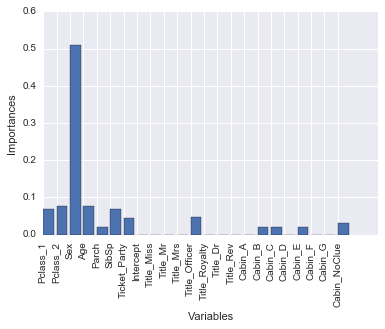

In [99]:
N = len(predictors_l)
ind = np.arange(N)
plt.bar(ind,dt_model.feature_importances_)
plt.xticks(ind, predictors_l, rotation='vertical')
plt.ylabel('Importances')
plt.xlabel('Variables')

On trace l'arbre de décision

In [92]:
import os

with open("titanictree.dot", 'w') as f:
    f = tree.export_graphviz(dt_results, feature_names=predictors_l, filled=True, rounded=True, out_file=f)
    
os.system('dot -Tpng titanictree.dot -o titanictree.png')
    

0

#### test predict 

In [12]:
test_x = test_df[predictors_l]

In [14]:
dt_predict = dt_results.predict(test_x)

In [15]:
result_df = pd.DataFrame([test_df.PassengerId, dt_predict], index=['PassengerId', "Survived"]).T
result_df.index = result_df['PassengerId']
result_df.drop('PassengerId', axis=1, inplace=True)

In [16]:
result_df.to_csv('dt_test.csv')

#### cross validation

In [95]:
kf = KFold(df.shape[0], n_folds=3, random_state=1)

predictions = []
for train, test in kf:
    train_predictors = (df[predictors_l].iloc[train,:])
    train_target = df[predicted].iloc[train]
    
    # scm friendly conversion 
    train_target = np.asarray(train_target)
    train_target = train_target.flatten()  
    
    dt_model = tree.DecisionTreeClassifier(criterion='entropy')
    dt_model.max_depth = 5
    dt_model.min_samples_split = 1
    
    # Training the algorithm using the predictors and target.
    dt_res = dt_model.fit(train_predictors ,train_target)
    # We can now make predictions on the test fold
    test_predictions = dt_res.predict(df[predictors_l].iloc[test,:])
    predictions.append(test_predictions)

In [96]:
prediction = np.concatenate(predictions)

dt_accuracy = (df['Survived'] == prediction).sum()*1./len(df)
print dt_accuracy

0.822671156004


In [100]:
kf = KFold(df.shape[0], n_folds=3, random_state=1)

results = []
index = []
for i in range(1,101):
    index.append(i)
    predictions = []
    for train, test in kf:
        train_predictors = (df[predictors_l].iloc[train,:])
        train_target = df[predicted].iloc[train]
    
        # scm friendly conversion 
        train_target = np.asarray(train_target)
        train_target = train_target.flatten()  
    
        dt_model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=i)
        # Training the algorithm using the predictors and target.
        dt_res = dt_model.fit(train_predictors ,train_target)
        # We can now make predictions on the test fold
        test_predictions = dt_res.predict(df[predictors_l].iloc[test,:])
        predictions.append(test_predictions)
    prediction = np.concatenate(predictions)
    dt_accuracy = (df['Survived'] == prediction).sum()*1./len(df)
    results.append(dt_accuracy)

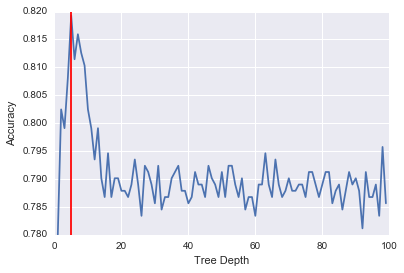

In [112]:
results = np.array(results)
best_depth = results.argmax()+1

plt.plot(index,results)
plt.ylabel('Accuracy')
plt.xlabel('Tree Depth')
plt.axvline(x=best_depth, color='r')

### Random Forest 

In [142]:
rf_model = ensemble.RandomForestClassifier(n_estimators=1000, criterion='entropy')

x = df[predictors_l]

y = pd.DataFrame(df[predicted])
y = np.asarray(y)
y = y.flatten()

rf_results = rf_model.fit(x,y)

score = rf_results.score(x, y)

score

0.94725028058361394

#### test predict 

In [128]:
test_x = test_df[predictors_l]

In [129]:
rf_predict = rf_results.predict(test_x)

In [130]:
result_df = pd.DataFrame([test_df.PassengerId, rf_predict], index=['PassengerId', "Survived"]).T
result_df.index = result_df['PassengerId']
result_df.drop('PassengerId', axis=1, inplace=True)

In [131]:
result_df.to_csv('rf_test.csv')

#### cross validation

In [140]:
kf = KFold(df.shape[0], n_folds=3, random_state=1)

predictions = []
for train, test in kf:
    train_predictors = (df[predictors_l].iloc[train,:])
    train_target = df[predicted].iloc[train]
    
    # scm friendly conversion 
    train_target = np.asarray(train_target)
    train_target = train_target.flatten()  
    
    rf_model = ensemble.RandomForestClassifier(n_estimators=100, criterion='gini', max_features=4, max_leaf_nodes=12,
                                               min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0)
    # Training the algorithm using the predictors and target.
    rf_res = rf_model.fit(train_predictors ,train_target)
    # We can now make predictions on the test fold
    test_predictions = rf_res.predict(df[predictors_l].iloc[test,:])
    predictions.append(test_predictions)

In [141]:
prediction = np.concatenate(predictions)

svm_accuracy = (df['Survived'] == prediction).sum()*1./len(df)
print svm_accuracy

0.820426487093


### Other

In [88]:
knn = neighbors.KNeighborsClassifier(n_neighbors = 3, p=2)

x = df[predictors_l]
y = pd.DataFrame(df[predicted])

y = np.asarray(y)
y = y.flatten()

knn_results = knn.fit(x, y)

knn_results.score(x, y)

0.87654320987654322

In [90]:
# test 
test_x = test_df[predictors_l]
knn_pred = knn_results.predict(test_x)

In [91]:
result_df = pd.DataFrame([test_df.PassengerId, knn_pred], index=['PassengerId', "Survived"]).T
result_df.index = result_df['PassengerId']
result_df.drop('PassengerId', axis=1, inplace=True)

In [92]:
result_df.to_csv('knn_test.csv')

In [94]:
# cross validation 

kf = KFold(df.shape[0], n_folds=3, random_state=1)

predictions = []
for train, test in kf:
    train_predictors = (df[predictors_l].iloc[train,:])
    train_target = df[predicted].iloc[train]
    
    # scm friendly conversion 
    train_target = np.asarray(train_target)
    train_target = train_target.flatten()  
    
    knn_model = neighbors.KNeighborsClassifier(n_neighbors = 3, p=2)
    # Training the algorithm using the predictors and target.
    knn_res = knn_model.fit(train_predictors ,train_target)
    # We can now make predictions on the test fold
    test_predictions = knn_res.predict(df[predictors_l].iloc[test,:])
    predictions.append(test_predictions)

In [95]:
prediction = np.concatenate(predictions)

knn_accuracy = (df['Survived'] == prediction).sum()*1./len(df)
print knn_accuracy

0.793490460157


In [96]:
# Gaussian Naive Bayes

gaussian = naive_bayes.GaussianNB()

x = df[predictors_l]
y = pd.DataFrame(df[predicted])

y = np.asarray(y)
y = y.flatten()

gaussian_results = gaussian.fit(x, y)

gaussian_results.score(x, y)

0.78563411896745228

In [97]:
# test
test_x = test_df[predictors_l]
gaussian_pred = gaussian_results.predict(test_x)

result_df = pd.DataFrame([test_df.PassengerId, gaussian_pred], index=['PassengerId', "Survived"]).T
result_df.index = result_df['PassengerId']
result_df.drop('PassengerId', axis=1, inplace=True)

result_df.to_csv('gaussian_test.csv')

In [99]:
# cross validation 

kf = KFold(df.shape[0], n_folds=3, random_state=1)

predictions = []
for train, test in kf:
    train_predictors = (df[predictors_l].iloc[train,:])
    train_target = df[predicted].iloc[train]
    
    # scm friendly conversion 
    train_target = np.asarray(train_target)
    train_target = train_target.flatten()  
    
    gaussian_model = naive_bayes.GaussianNB()
    # Training the algorithm using the predictors and target.
    gaussian_res = gaussian_model.fit(train_predictors ,train_target)
    # We can now make predictions on the test fold
    test_predictions = gaussian_res.predict(df[predictors_l].iloc[test,:])
    predictions.append(test_predictions)

In [100]:
prediction = np.concatenate(predictions)

gaussian_accuracy = (df['Survived'] == prediction).sum()*1./len(df)
print gaussian_accuracy

0.652076318743
